# Статистическая значимость эксперимента

In [16]:
import numpy as np
from numpy import array

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.power import NormalIndPower
from savvy import expirements_metrics

import matplotlib.pyplot as plt
import seaborn as sns

## Расчет мощности теста
Мощность теста - это вероятность верно отлонить нулевую гипотезу, при условии наличия эффекта

### 1. Расчет мощности для t- и z-тестов, используя библиотеку statsmodels**

Потребуется задать:
* величину стандартизированного эффекта (индекс Коэна), т.е. разницу между средними, делённую на стандартное отклонение
* размер имеющейся выборки
* уровень значимости

In [17]:
# исходные данные
mean_control = 1                               # ср. значение в контрольной группе
mean_treatment = 1.1                           # ср. значение в тестовой группе с учетом прироста
delta = abs(mean_treatment - mean_control)     # ожидаемый менеджером прирост
sd_mean_control = 1                            # стандартное отклонение в контрольной группе
sd_mean_treatment = 1                          # стандартное отклонение в тестовой группе
sample_size = 200 # размер имеющейся выборки
alpha = 0.05 # установленный уровень значимости

# расчет стандартизированного эффекта (индекса Коэна) для разницы средних
effect_size = expirements_metrics.calc_Cohen_d_by_params(mean_control, mean_treatment,
                                                         sd_mean_control, sd_mean_treatment)
# Мощность t-теста
t_test_power = (
    TTestIndPower().power(
                effect_size = round(effect_size, 3),
                nobs1 = sample_size,
                alpha = alpha)
             )

print(f"Вероятность, что T-тест зафиксирует эффект в {effect_size} \
(мощность):", "{:.1%}".format(t_test_power))

# Мощность z-теста
z_test_power = (
    NormalIndPower().solve_power(
                effect_size = effect_size,
                nobs1 = sample_size,
                alpha = alpha)
             )
print(f"Вероятность, что z-тест зафиксирует эффект в {effect_size} \
(мощность):", "{:.1%}".format(z_test_power))

Вероятность, что T-тест зафиксирует эффект в 0.1 (мощность): 16.9%
Вероятность, что z-тест зафиксирует эффект в 0.1 (мощность): 17.0%


### 2. Расчет MDE (размера эффекта) по параметрам теста

* Существует два типа проверки гипотез:
Двусторонний тест: альтернативная гипотеза содержит знак ≠
Односторонний тест: альтернативная гипотеза содержит знак < или >

In [18]:
MDE_std = tt_ind_solve_power(effect_size = None,
                       alpha = alpha,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = sample_size)
print(f'Стандартизированный MDE, который мы можем себе позволить на заданном дизайне эксперимента = {MDE_std}, Абсолютный MDE: {MDE_std * sd_mean_control}')

Стандартизированный MDE, который мы можем себе позволить на заданном дизайне эксперимента = 0.2808352254289379, Абсолютный MDE: 0.2808352254289379


### 3. Расчет размера выборки

In [19]:
sample_size = tt_ind_solve_power(effect_size = MDE_std,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = None)
print('Размер выборки под заданный MDE = ', round(sample_size))

Размер выборки под заданный MDE =  200


## 2. Расчет мощности теста, исходя из имеющегося размера выборки, используя симуляции

In [20]:
rel_delta = 0.1               # относительный размер эффекта
control_mean = 1              # ср. в контрольной группе
control_sd = 1                # ст. отклонение в контрольной группе
sample_size = 200     # размер выборки из предыдущего расчета
alpha = 0.05                  # уровень значимости
n_sim = 10000                 # количество повторных симуляций
np.random.seed(123)

In [21]:
# сгенерируем нормальные данные n_sim раз (множество пар выборок)
def simulate_data(control_mean, control_sd, rel_delta, sample_size, n_sim):
    # Генерация значений для нулевой гипотезы из нормального распределения с заданными параметрами
    control = np.random.normal(loc = control_mean,
                               scale = control_sd,
                               size = (round(sample_size), n_sim))

    # Генерация значений для альтернативной гипотезы из нормального распределения с заданными параметрами
    treatment = np.random.normal(loc = control_mean*(1 + rel_delta),
                                 scale = control_sd,
                                 size = (round(sample_size), n_sim))
    return control, treatment

control, treatment = simulate_data(control_mean,
                                   control_sd,
                                   rel_delta,
                                   sample_size,
                                   n_sim)

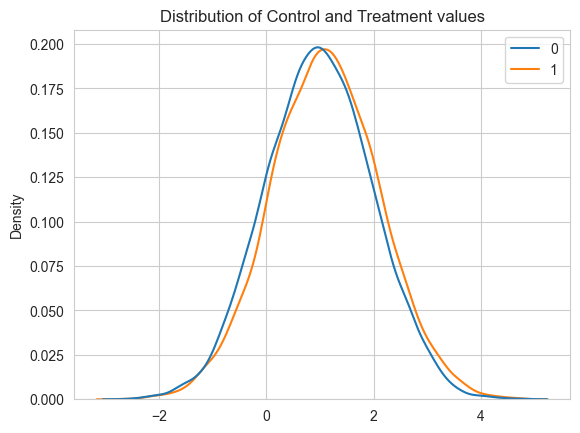

In [22]:
# Пример распределений для 2-х гипотез в одной из симуляций
sns.kdeplot(data=[control[100], treatment[100]])
plt.grid(True)
plt.title('Distribution of Control and Treatment values')
plt.show()

In [23]:
# Проведение t-теста
t_stat_list, p_value_list = ss.ttest_ind(control, treatment)

In [24]:
power = (p_value_list < 0.05).sum() / n_sim
print("Мощность эксперимента: {:.1%}".format(power))

Мощность эксперимента: 17.2%


## 3. Анализ мощности

### 3.1 Расчет размера выборки для достижения требуемой мощности

#### 3.1.1 Расчет размера выборки, используя аналитический метод

In [25]:
rel_effect = 0.1         # минимальный аплифт, который ожидает менеджер
control_mean = 1         # среднее в контрольной группе
control_sd = 1           # стандартное отклонение в контрольной группе
alpha = 0.05             # уровень значимости

treat_mean = control_mean * (1 + rel_effect)
cohen_d = expirements_metrics.calc_Cohen_d_by_params(mean_control=control_mean,
                                                     mean_test=treat_mean,
                                                     sd_control=control_sd,
                                                     sd_test=control_sd)

n = tt_ind_solve_power(effect_size = cohen_d,
                       alpha = alpha,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided")
print('Минимальный размер выборки для достижения уровня значимости: {:.0f}'.format(round(n)))

Минимальный размер выборки для достижения уровня значимости: 1571


#### 3.1.2 Расчет размера выборки используя приближенную формулу

In [26]:
delta =cohen_d
sample_size = 15.7 * control_sd**2 / cohen_d**2
print('Минимальный размер выборки: {:.0f}'.format(round(sample_size)))

Минимальный размер выборки: 1570


### 3.1.3 Расчет размера выборки, используя симуляции

Text(0.5, 0, 'Sample size')

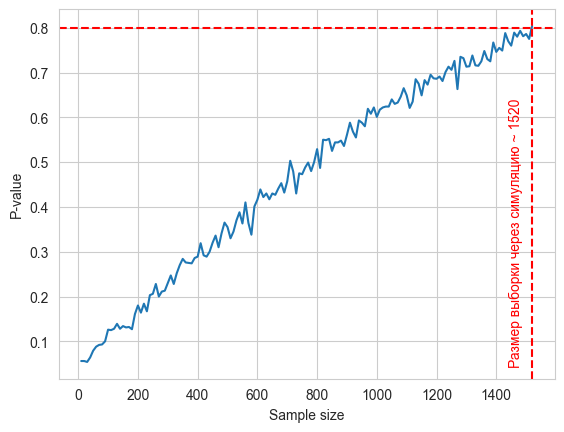

In [27]:
sample_size_start = 10         # начальный размер выборки для симуляции
power_set = 0.8                # требуемый уровень мощности теста
alpha = 0.05                   # уровень значимости
control_mean = 1               # среднее в контрольной группе
control_sd = 1                 # стандартное отклонение в контрольной группе
n_sim = 1000                   # количество повторных симуляций
rel_delta = 0.1                # относительный прирост, относительный MDE

power_value_list = []
sample_size_list = []
while True:
    p_value_list = []
    group_a, group_b_with_effect = simulate_data(control_mean, control_sd, rel_delta, sample_size_start, n_sim)
    t_stat, p_value = ss.ttest_ind(group_a, group_b_with_effect)
    p_value_list.append(p_value)
    power_value = (np.array(p_value_list) < 0.05).mean()
    power_value_list.append(power_value)
    sample_size_list.append(sample_size_start)
    if power_value > power_set:
        break
    else:
        sample_size_start += 10
final_sample_size = sample_size_start

sns.lineplot(x= sample_size_list, y = power_value_list)
plt.axhline(y = 0.8, linestyle  = '--', color = 'red')
plt.axvline(x = sample_size_start, linestyle  = '--', color = 'red')
plt.text(x = round(sample_size_start*0.95),
         y = 0.05,
         s = 'Размер выборки через симуляцию ~ {}'.format(sample_size_start),
        rotation = 'vertical',
        color = 'red')
plt.grid(True)
plt.ylabel("P-value")
plt.xlabel("Sample size")

## Величина эффекта для пропорций

Jacob Cohen. Statistical Power Analysis for the Behavioral Sciences (стр.182): </br>
https://www.taylorfrancis.com/books/mono/10.4324/9780203771587/statistical-power-analysis-behavioral-sciences-jacob-cohen

Стандартизация величины эффекта для пропорций:</br> https://www.statsmodels.org/dev/_modules/statsmodels/stats/proportion.html#proportion_effectsize

$$
d = 2 * (arcsin({p_1}^{1/2}) - arcsin({p_2}^{1/2}))
$$

Alpha=0.1
Размер выборки для каждой группы, необходимый, чтобы задетектить эффект в 10.0%:  11613.3479194104


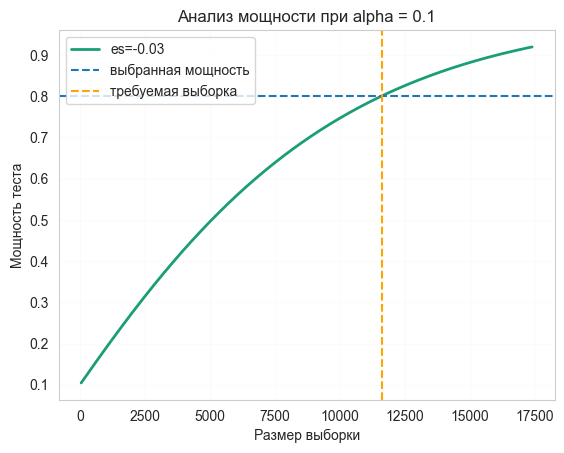

Alpha=0.05
Размер выборки для каждой группы, необходимый, чтобы задетектить эффект в 10.0%:  14744.10483692551


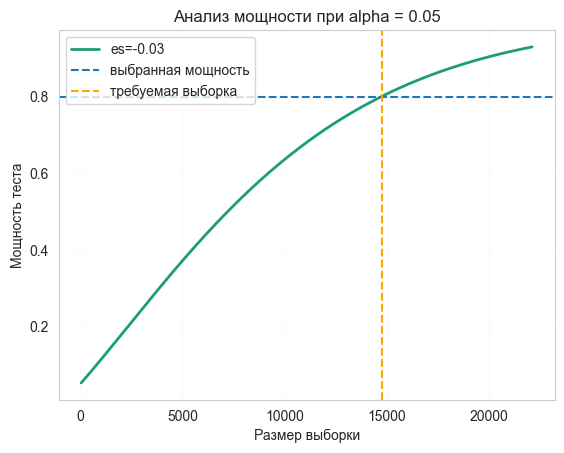

Alpha=0.01
Размер выборки для каждой группы, необходимый, чтобы задетектить эффект в 10.0%:  21938.971977388963


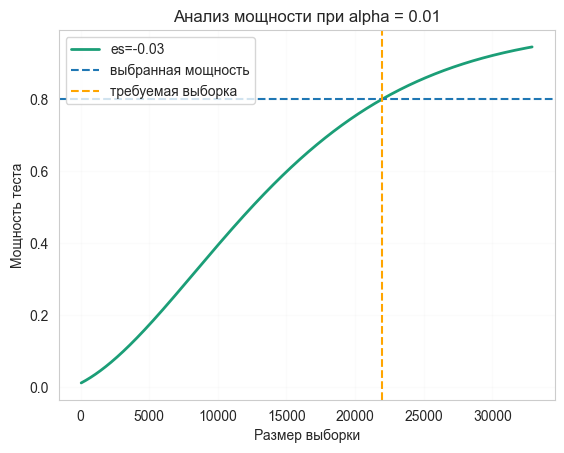

In [28]:
rel_mde = 0.1 # минимальный размер эффекта, который хотим задетектить относительный
# пропорции, если эффект присутствует
p1 = 0.10            # контрольная группа (старый логотип)
p2 = p1 * (1 + rel_mde)   # тестовая группа (новый логотип)

for alpha in [0.1, 0.05, 0.01]:
    expirements_metrics.calc_sample_size_ztest_analysis(p1=p1, p2=p2, alpha=alpha, rel_mde=rel_mde, plot=True)

### 4. Влияние величины эффекта на размер выборки для требуемой мощности

In [29]:
p1 = [0.1, 0.08, 0.05]
p2 = [0.11, 0.0864, 0.0525]

d = sm.stats.proportion_effectsize(p1, p2)
effect_sizes = array(d)

n = round(tt_ind_solve_power(effect_size=max(effect_sizes), power=power, alpha=alpha))
sample_sizes = array(range(5, n+1000))

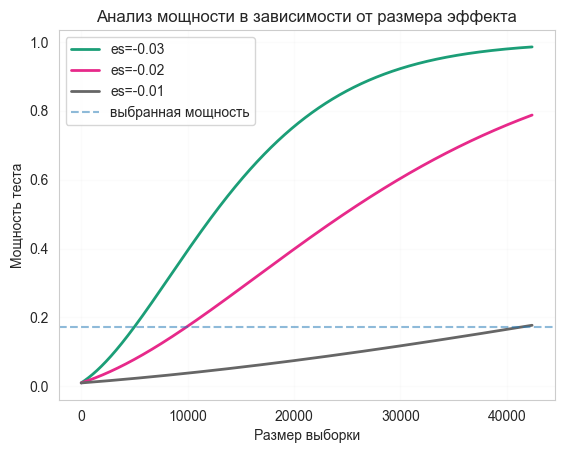

In [30]:
sms.NormalIndPower().plot_power(
     dep_var='nobs', nobs=sample_sizes,
     effect_size=effect_sizes, alpha = alpha, title='Анализ мощности в зависимости от размера эффекта')

# график, показывающий размер выборки для различных эффектов и заданной мощности
plt.axhline(power, linestyle='--', label='выбранная мощность', alpha=0.5)
plt.ylabel('Мощность теста')
plt.xlabel('Размер выборки')
plt.grid(alpha=0.08)
plt.legend()
plt.show()